Columns read: Index(['time', 'gFx', 'gFy', 'gFz'], dtype='object')
t min / max : 0.0 9.554
    time  time_min      enmo
0 -5.259  0.000000  4.383875
1 -4.165  0.018233  3.465284
2 -4.131  0.018800  3.168768
3 -4.120  0.018983  3.143891
4 -3.977  0.021367  3.174278


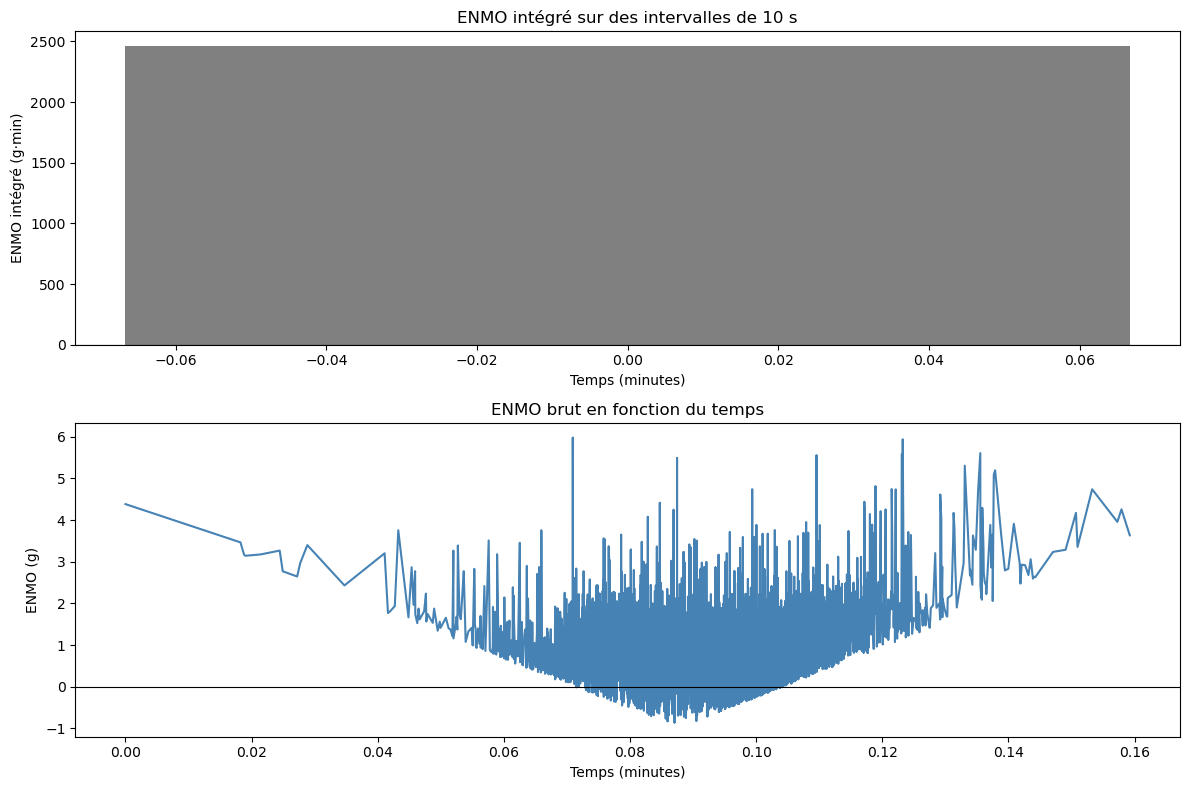

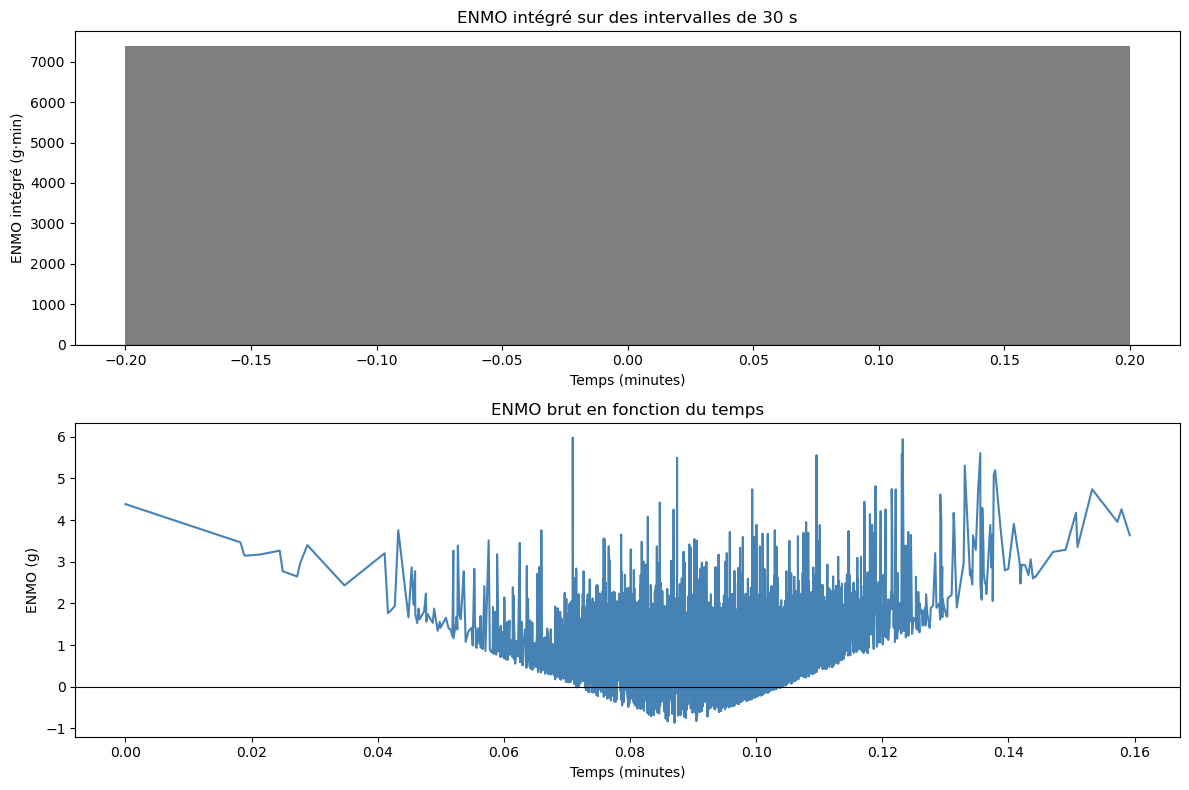

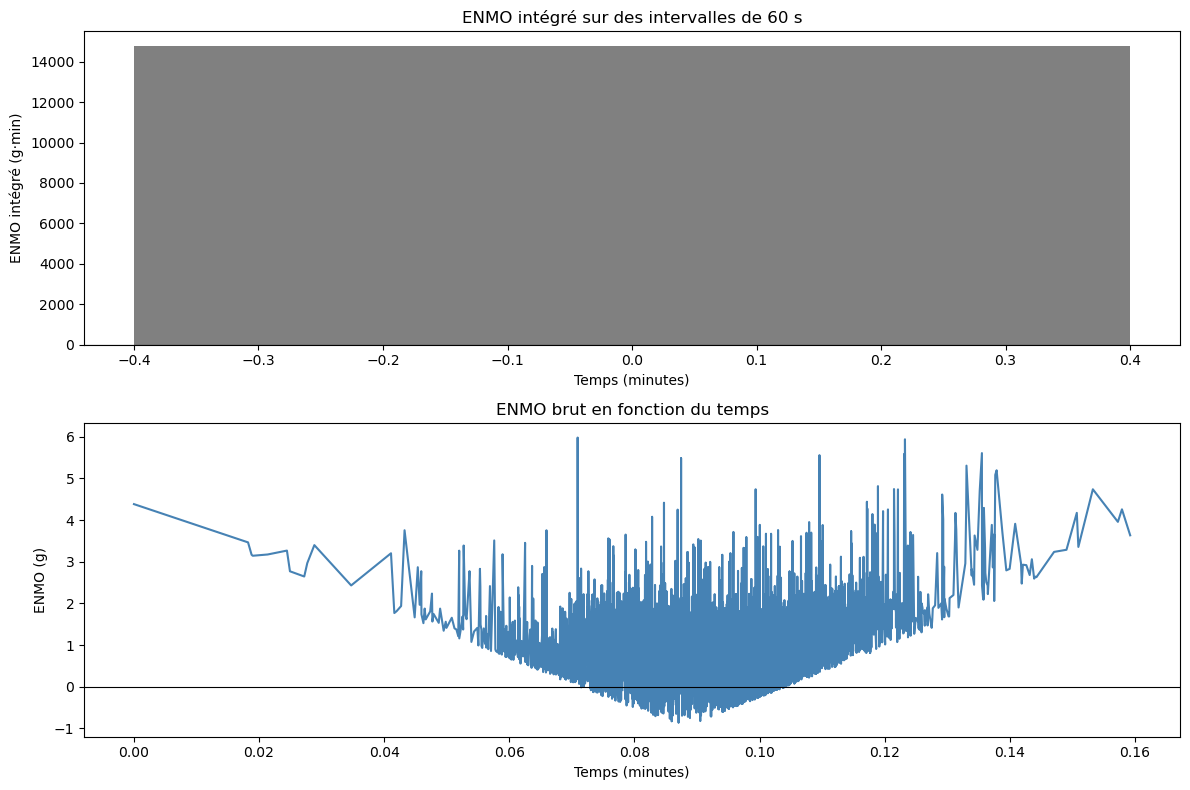

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1) Lecture du CSV
# =========================
path = r"../data/wrist_Series1_trial2.csv"  # adapte si besoin
df = pd.read_csv(path)

print("Columns read:", df.columns)
# On suppose: time,gFx,gFy,gFz

# =========================
# 2) Temps et axes en numérique
# =========================
df["time"] = pd.to_numeric(df["time"], errors="coerce")

for c in ["gFx", "gFy", "gFz"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["time", "gFx", "gFy", "gFz"]).reset_index(drop=True)

# On renomme pour coller à ta fonction compute_enmo
df = df.rename(columns={"gFx": "x", "gFy": "y", "gFz": "z"})

# On ordonne par temps croissant
df = df.sort_values("time").reset_index(drop=True)

# Temps relatif t >= 0 (en secondes) et en minutes
df["t"] = df["time"] - df["time"].iloc[0]
df["time_min"] = df["t"] / 60.0

print("t min / max :", df["t"].min(), df["t"].max())

# =========================
# 3) Ta fonction ENMO
# =========================
def compute_enmo(df):
    norm = np.sqrt(df["x"]**2 + df["y"]**2 + df["z"]**2)
    df["enmo"] = norm - 1  # keep negative values
    return df

df = compute_enmo(df)
print(df[["time", "time_min", "enmo"]].head())

# =========================
# 4) Ta fonction d’agrégation
# =========================
def aggregate_enmo_gmin(df, epoch_length):
    df_local = df.copy()
    df_local["epoch"] = (df_local["t"] // epoch_length).astype(int)
    aggregated = df_local.groupby("epoch")["enmo"].sum().reset_index()
    aggregated["enmo_gmin"] = aggregated["enmo"] * (epoch_length / 60)
    aggregated["time_min"] = aggregated["epoch"] * epoch_length / 60
    return aggregated

# =========================
# 5) Boucle sur les longueurs d’epoch + graphes
# =========================
epoch_lengths = [10, 30, 60]   # secondes

for epoch_length in epoch_lengths:
    aggregated = aggregate_enmo_gmin(df, epoch_length=epoch_length)

    fig, axs = plt.subplots(2, 1, figsize=(12, 8))

    bar_width = 0.8 * (epoch_length / 60.0)

    # ----- Graphe 1 : ENMO agrégé -----
    axs[0].bar(aggregated["time_min"], aggregated["enmo_gmin"],
               width=bar_width, color="grey")
    axs[0].set_title(f"ENMO intégré sur des intervalles de {epoch_length} s")
    axs[0].set_ylabel("ENMO intégré (g·min)")
    axs[0].set_xlabel("Temps (minutes)")
    axs[0].axhline(0, color="black", linewidth=0.8)

    # ----- Graphe 2 : ENMO brut -----
    axs[1].plot(df["time_min"], df["enmo"], color="steelblue")
    axs[1].set_title("ENMO brut en fonction du temps")
    axs[1].set_xlabel("Temps (minutes)")
    axs[1].set_ylabel("ENMO (g)")
    axs[1].axhline(0, color="black", linewidth=0.8)

    plt.tight_layout()
    plt.show()   # <--- affiche seulement, ne sauvegarde rien
